# Italy Covid 19 data analysis and visualization

**Author**: Fabio Sona<br>
**Date**: 22 January 2021<br>
**Content**<br>
Data visualization and analyisis of Italian Covid 19 data retrieved on daily basis from opendata repository managed, on github, by "**Protezione Civile**" an Italian Agency in charge of supporting Government in managing emergencies across the country




In [ ]:
# import lib/modules
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import FuncFormatter
import matplotlib.dates as mdates
from matplotlib.dates import MO, TU, WE, TH, FR, SA, SU
import datetime
from datetime import date
import numpy as np
from matplotlib.offsetbox import AnchoredText
import seaborn as sns
import scipy.special as sps  


In [ ]:
#%%
# Read region based data  from repository of Protezione Civile 
dfREG0=pd.read_json("https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-json/dpc-covid19-ita-regioni.json")
#dfREG0.info()

#Convert to Datetime Function 
def convertDate(d):
     new_date = datetime.datetime.strptime(d,"%Y-%m-%dT%H:%M:%S")
     return new_date.date()
#%%
dfREG=dfREG0.copy() #create a working copy for dataset
dfREG['data'] = dfREG['data'].apply(convertDate) #convert data in DateTime
dfREG=dfREG.set_index(['data']) # set 'data' column as index
dfREG=(dfREG.loc[pd.to_datetime('2020-09-01'):]) #Take everything after Sept 1st, 2020 
regioni=dfREG['denominazione_regione'].unique() #Extract list of regions


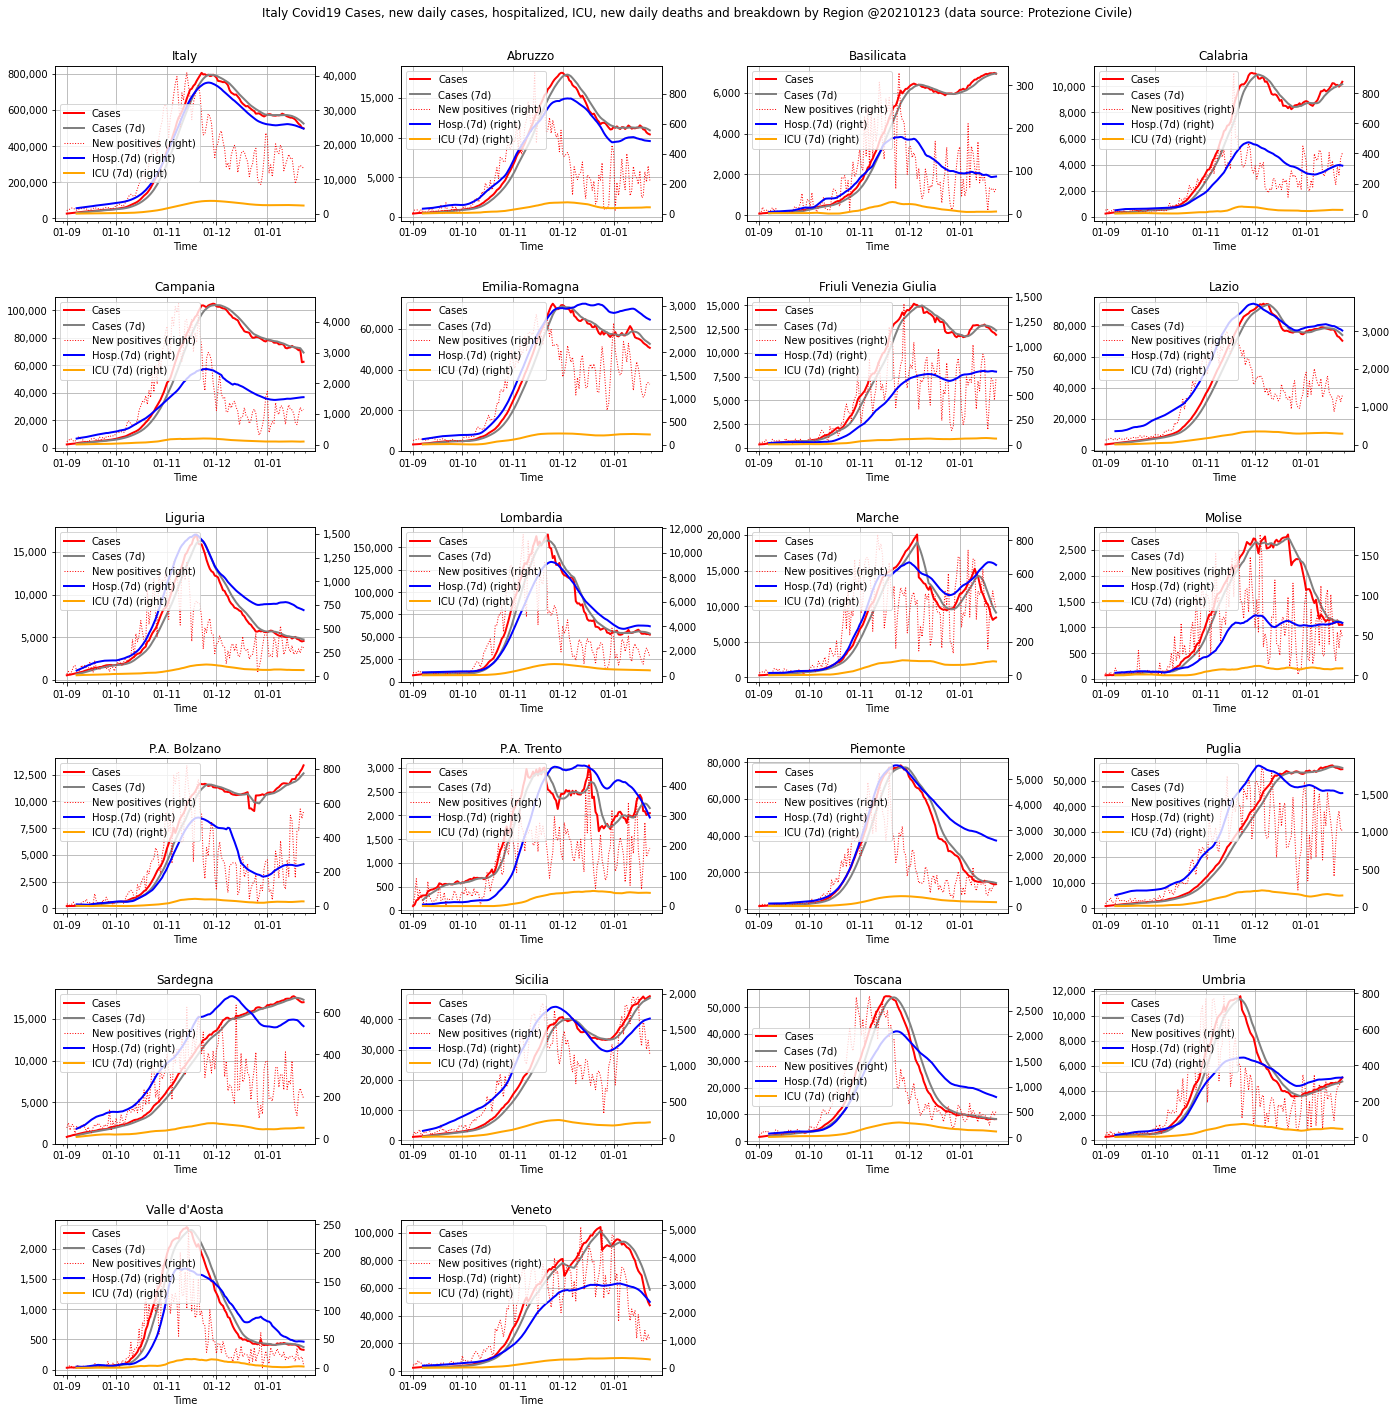

In [ ]:
#%%
#Plot main data
#1.Active cases , daily basis and moving average over 7 days, on primary axis
#2.Dailiy new positives, and moving average over 7 days fof Hospitalization and ICU on secondary axis 
nrows=6 
ncols=4
fig, axes = plt.subplots(nrows, ncols,sharex=False,figsize=(20,20)) #
fig.tight_layout(pad=5.5)

date_form = mdates.DateFormatter("%d-%m") #Format date into dd-mm format
MA=7 #moving average window

def reformat_large_tick_values(tick_val, pos):
    """
    Format thousands into X.X K
    """
    val = round(tick_val/1000, 1)
    new_tick_format = '{:}K'.format(val)
      
    return new_tick_format

#Main Loop to fill the subplots matrix
idx=0
for r in range(nrows):
  for c in range(ncols):
    if r==0 and c==0: #First box for Nationwide data
      df=dfREG.groupby(['data']).sum()
      title='Italy'
    elif  idx<=20 : #then plot regions individually
      regtarget=regioni[idx]
      df=dfREG.copy()
      df=df[df.denominazione_regione.str.contains(regtarget)==True]
      title=regtarget
      idx=idx+1
    else:
      break
      
    df['totale_positivi'].plot(kind='line', linestyle="-",lw=2,color='red',grid=True,rot=0,legend=False,label='Cases',ax=axes[r,c],sharex=False)
    df['totale_positivi'].rolling(window=MA).mean().plot(kind='line', linestyle="-",lw=2,color='grey',grid=True,rot=0,legend=False,label='Cases (7d)',ax=axes[r,c],sharex=False)
    axes[r,c].set_xlabel('Time')
    axes[r,c].yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
      
    ax2=axes[r,c].twinx()
    df['nuovi_positivi'].plot(kind='line',linestyle=":",lw=1,color='red',grid=False,rot=0,legend=False,label='New positives (right)',ax=ax2,sharex=False)
    df['totale_ospedalizzati'].rolling(window=MA).mean().plot(kind='line',linestyle="-",lw=2,color='blue',grid=False,rot=0,legend=False,label='Hosp.(7d) (right)',ax=ax2)
    df['terapia_intensiva'].rolling(window=MA).mean().plot(kind='line',linestyle="-",lw=2,color='orange',grid=False,rot=0,legend=False,label='ICU (7d) (right)',ax=ax2) 

    lines, labels = axes[r,c].get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc=0)
    ax2.set_xlabel('Time')
    
    ax2.xaxis.set_major_locator(mdates.MonthLocator())
    ax2.xaxis.set_major_formatter(date_form)
    ax2.xaxis.set_minor_locator(mdates.WeekdayLocator(byweekday=SU))
    ax2.xaxis.set_minor_formatter(ticker.NullFormatter())   
    ax2.yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
    axes[r,c].set_title(title)



#Put back bottom labels and clean up unused plots (last two after Italy + 21 regions)
idx=0
for r in range(nrows):
 for c in range(ncols):
     if idx < 22:
         axes[r,c].tick_params(labelbottom=True)
         x_axis=axes[r,c].get_xaxis()
         x_label=x_axis.get_label()
         x_label.set_visible(True)
     else:
         axes[r,c].set_visible(False)
     idx=idx+1
     
today=df.index[-1] #Get last date ov relevant data 
d=today.strftime("%Y%m%d")
fig.suptitle('Italy Covid19 Cases, new daily cases, hospitalized, ICU, new daily deaths and breakdown by Region @'+d+' (data source: Protezione Civile)',y=1.0, x=0.5) 
plt.savefig(d+'ItalyDashboardMain.png')
plt.show()


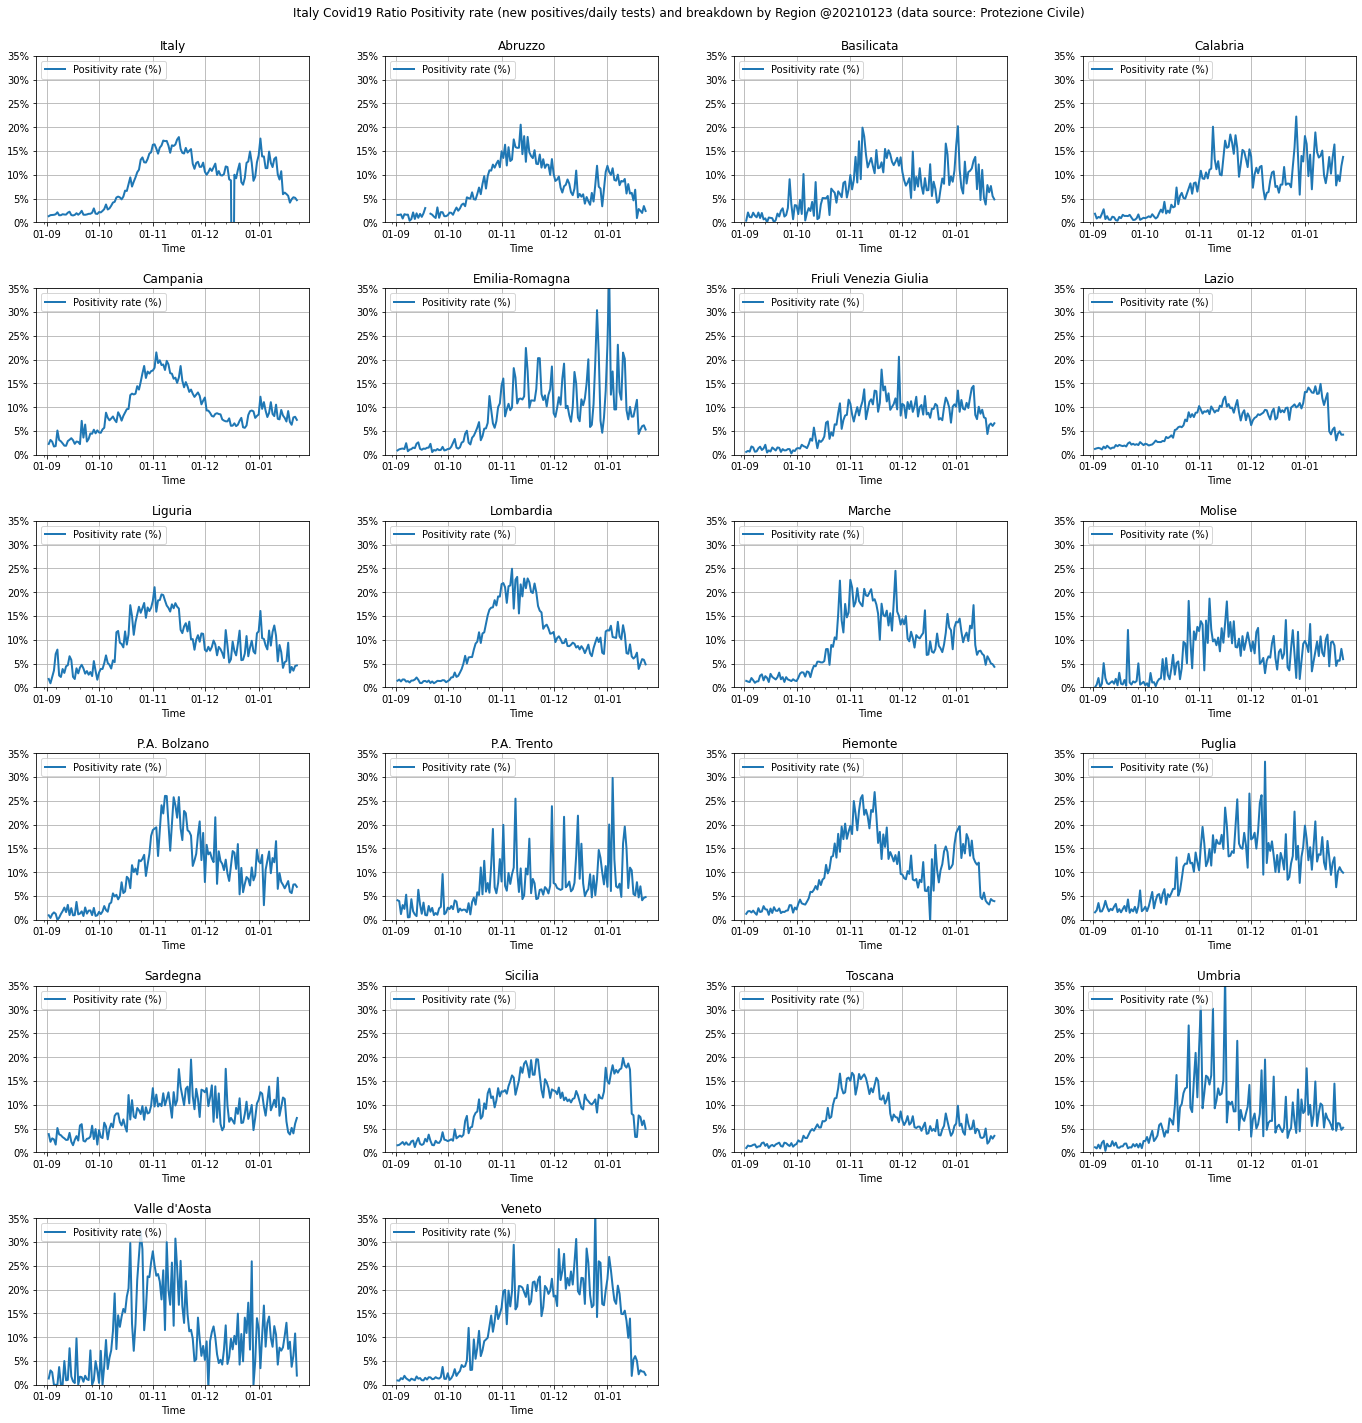

In [ ]:
#%%
#Plot ratio new positives / new test
nrows=6 
ncols=4
fig, axes = plt.subplots(nrows, ncols,sharex=False,figsize=(20,20)) #
fig.tight_layout(pad=4.5)

date_form = mdates.DateFormatter("%d-%m") #Format date into dd-mm format
MA=7 #moving average window

def reformat_large_tick_values(tick_val, pos):
    """
    Format thousands into X.X K
    """
    val = round(tick_val/1000, 1)
    new_tick_format = '{:}K'.format(val)
      
    return new_tick_format

#Main Loop to fill the subplots matrix
idx=0
for r in range(nrows):
  for c in range(ncols):
    if r==0 and c==0: #First select Nationwide data
      df=dfREG.groupby(['data']).sum()
      title='Italy'
    elif  idx<=20 : #then select dataframe on a regional basis
      regtarget=regioni[idx]
      df=dfREG.copy()
      df=df[df.denominazione_regione.str.contains(regtarget)==True]
      title=regtarget
      idx=idx+1
    else:
      break
      
    df['nuovi_tamponi']=df['tamponi'].diff()
    df['pos_tamponi']=df['nuovi_positivi']/df['nuovi_tamponi']
    df['pos_tamponi'].plot(kind='line', linestyle="-",lw=2,grid=True,rot=0,legend=True,label='Positivity rate (%)',ax=axes[r,c],sharex=False)

    axes[r,c].set_xlabel('Time')
    axes[r,c].xaxis.set_major_formatter(date_form)
    axes[r,c].xaxis.set_major_locator(mdates.MonthLocator())
    axes[r,c].xaxis.set_minor_locator(mdates.WeekdayLocator(byweekday=SU))
    axes[r,c].xaxis.set_minor_formatter(ticker.NullFormatter())
    axes[r,c].set_ylim([0,0.35])    
    axes[r,c].yaxis.set_major_formatter(FuncFormatter('{0:.0%}'.format))
    
    axes[r,c].legend(loc='upper left')
    axes[r,c].set_title(title)

#Put back bottom labels and clean up unused plots (last two after Italy + 21 regions)
idx=0
for r in range(nrows):
 for c in range(ncols):
     if idx < 22:
         axes[r,c].tick_params(labelbottom=True)
         x_axis=axes[r,c].get_xaxis()
         x_label=x_axis.get_label()
         x_label.set_visible(True)
     else:
         #fig.delaxes(axes[r,c])
         axes[r,c].set_visible(False)
     idx=idx+1
     
today=df.index[-1]
d=today.strftime("%Y%m%d")
fig.suptitle('Italy Covid19 Ratio Positivity rate (new positives/daily tests) and breakdown by Region @' +d+' (data source: Protezione Civile)',y=1.0, x=0.5) 
plt.savefig(d+'ItalyDashboardRatio.png')
plt.show()



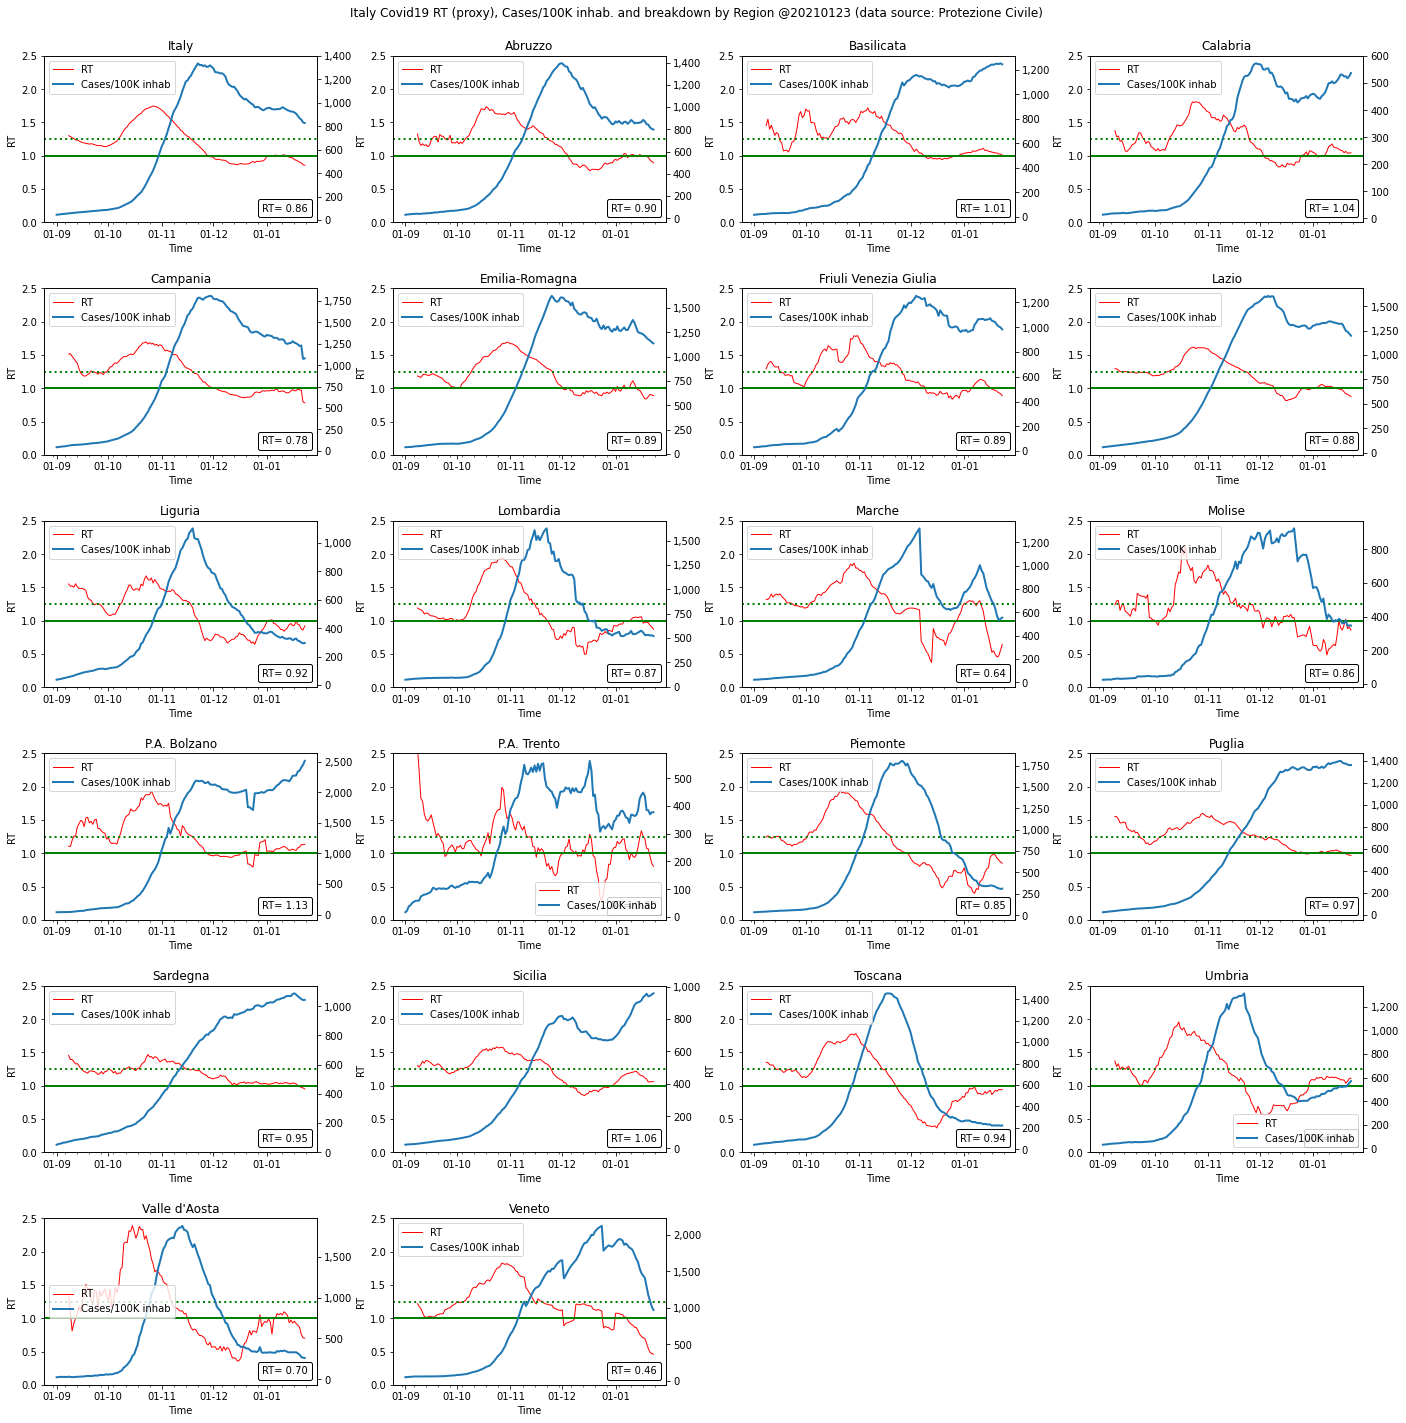

In [ ]:
#%%
#Plot R(t) on primary axis and cases/100K inhabitants on secnday axis
# R(t) calculation is a proxy based on https://www.scienzainrete.it/articolo/modo-semplice-calcolare-rt/roberto-battiston/2020-11-20c

k=7 #days basis calcuation of derivative of Ln Cases
ht=6.6
gamma=1/9 #Inverse of recovery days 9
nrows=6 
ncols=4
fig, axes = plt.subplots(nrows, ncols,sharex=False,figsize=(20,20)) #
fig.tight_layout(pad=4.5)

#Population data colleced manually from various sources
population = {'geo': ['Italy','Lombardia', 'Lazio','Campania','Sicilia','Veneto','Emilia-Romagna','Piemonte','Puglia','Toscana','Calabria','Sardegna','Liguria','Marche','Abruzzo','Friuli Venezia Giulia','P.A. Trento','P.A. Bolzano','Trentino-Alto Adige','Umbria','Basilicata','Molise',"Valle d'Aosta"],
        'ab': [60244639,10103969,5865544,5785861,4968410,4907704,4467118,4341375,4008296,3722729,1924701,1630474,1543127,1518400,1305770,1211357,542739,532080,1074819,880285,556934,302265,125501]
        }

dfAb = pd.DataFrame (population, columns = ['geo','ab'])
dfAb.set_index("geo", inplace=True)

date_form = mdates.DateFormatter("%d-%m") #Format date into dd-mm format
MA=7 #moving average window

newpos=[]
geo = []
rt = []
ratio = []
regtarget=""
#Main Loop to fill the subplots matrix
idx=0
for r in range(nrows):
  for c in range(ncols):
    if r==0 and c==0: #First select Nationwide data
      df=dfREG.groupby(['data']).sum()
      title='Italy'
      regtarget=title
    elif  idx<=20 : #then select dataframe on a regional basis
      regtarget=regioni[idx]
      df=dfREG.copy()
      df=df[df.denominazione_regione.str.contains(regtarget)==True]
      title=regtarget
      idx=idx+1
    else:
      break

    geo.append(regtarget)     
    newpos.append(df['nuovi_positivi'].iloc[-1])
    df['tot_pos_ewma'] = df['totale_positivi'].ewm(halflife=ht).mean()
    df['LNCasi']=np.log(df['totale_positivi'])

    df['dLNCasi']=df['LNCasi'].diff(periods=k)/k
    df['RT']=(df['dLNCasi']+gamma)/gamma
    df['RT'].plot(kind='line',linestyle="-",lw=1,color='red',grid=False,rot=0,legend=False,label='RT',ax=axes[r,c],sharex=False)
  
   

    rt.append(df['RT'].iloc[-1])    
    
    axes[r,c].set_xlabel('Time')
    axes[r,c].set_title(title)
    axes[r,c].set_ylim([0,2.5])
    axes[r,c].axhline(y=1, color='g',lw=2, linestyle='-')
    axes[r,c].axhline(y=1.25, color='g',lw=2, linestyle=':')
    axes[r,c].set_ylabel("RT")
    
    lastdate=df.index[-1]
    lastrt=df.iloc[-1].RT
   
    rtval = "%.2f" % lastrt
    at = AnchoredText('RT= '+rtval, prop=dict(size=10), frameon=True,loc='lower right',)
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    axes[r,c].add_artist(at)
       
    ax2=axes[r,c].twinx()
    ab=(dfAb.loc[title].ab)
    df['ratiocasi']=df['totale_positivi']/ab*100000
    df['ratiocasi'].plot(kind='line', linestyle="-",lw=2,grid=False,rot=0,legend=False,label='Cases/100K inhab',ax=ax2,sharex=False)
    
    ratio.append(df['ratiocasi'].iloc[-1])

    lines, labels = axes[r,c].get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc=0)
    
    
    ax2.set_xlabel('Time')
    ax2.xaxis.set_major_locator(mdates.MonthLocator())
    ax2.xaxis.set_major_formatter(date_form)
    ax2.xaxis.set_minor_locator(mdates.WeekdayLocator(byweekday=SU))
    ax2.xaxis.set_minor_formatter(ticker.NullFormatter())
    ax2.yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
    axes[r,c].set_title(title)

    
    

#Put back bottom labels and clean up unused plots (last two after Italy + 21 regions)
idx=0
for r in range(nrows):
 for c in range(ncols):
     if idx < 22:
         axes[r,c].tick_params(labelbottom=True)
         x_axis=axes[r,c].get_xaxis()
         x_label=x_axis.get_label()
         x_label.set_visible(True)
     else:
         #fig.delaxes(axes[r,c])
         axes[r,c].set_visible(False)
     idx=idx+1
     

today=df.index[-1]
d=today.strftime("%Y%m%d")
fig.suptitle('Italy Covid19 RT (proxy), Cases/100K inhab. and breakdown by Region @' + d + ' (data source: Protezione Civile)',y=1.0, x=0.5) 
plt.savefig(d+'ItalyDashboardRT.png')
plt.show()

pm = pd.DataFrame({'RT': rt,'RATIO': ratio,'GEO': geo,'NP':newpos}) #Create data set for the following Cell 



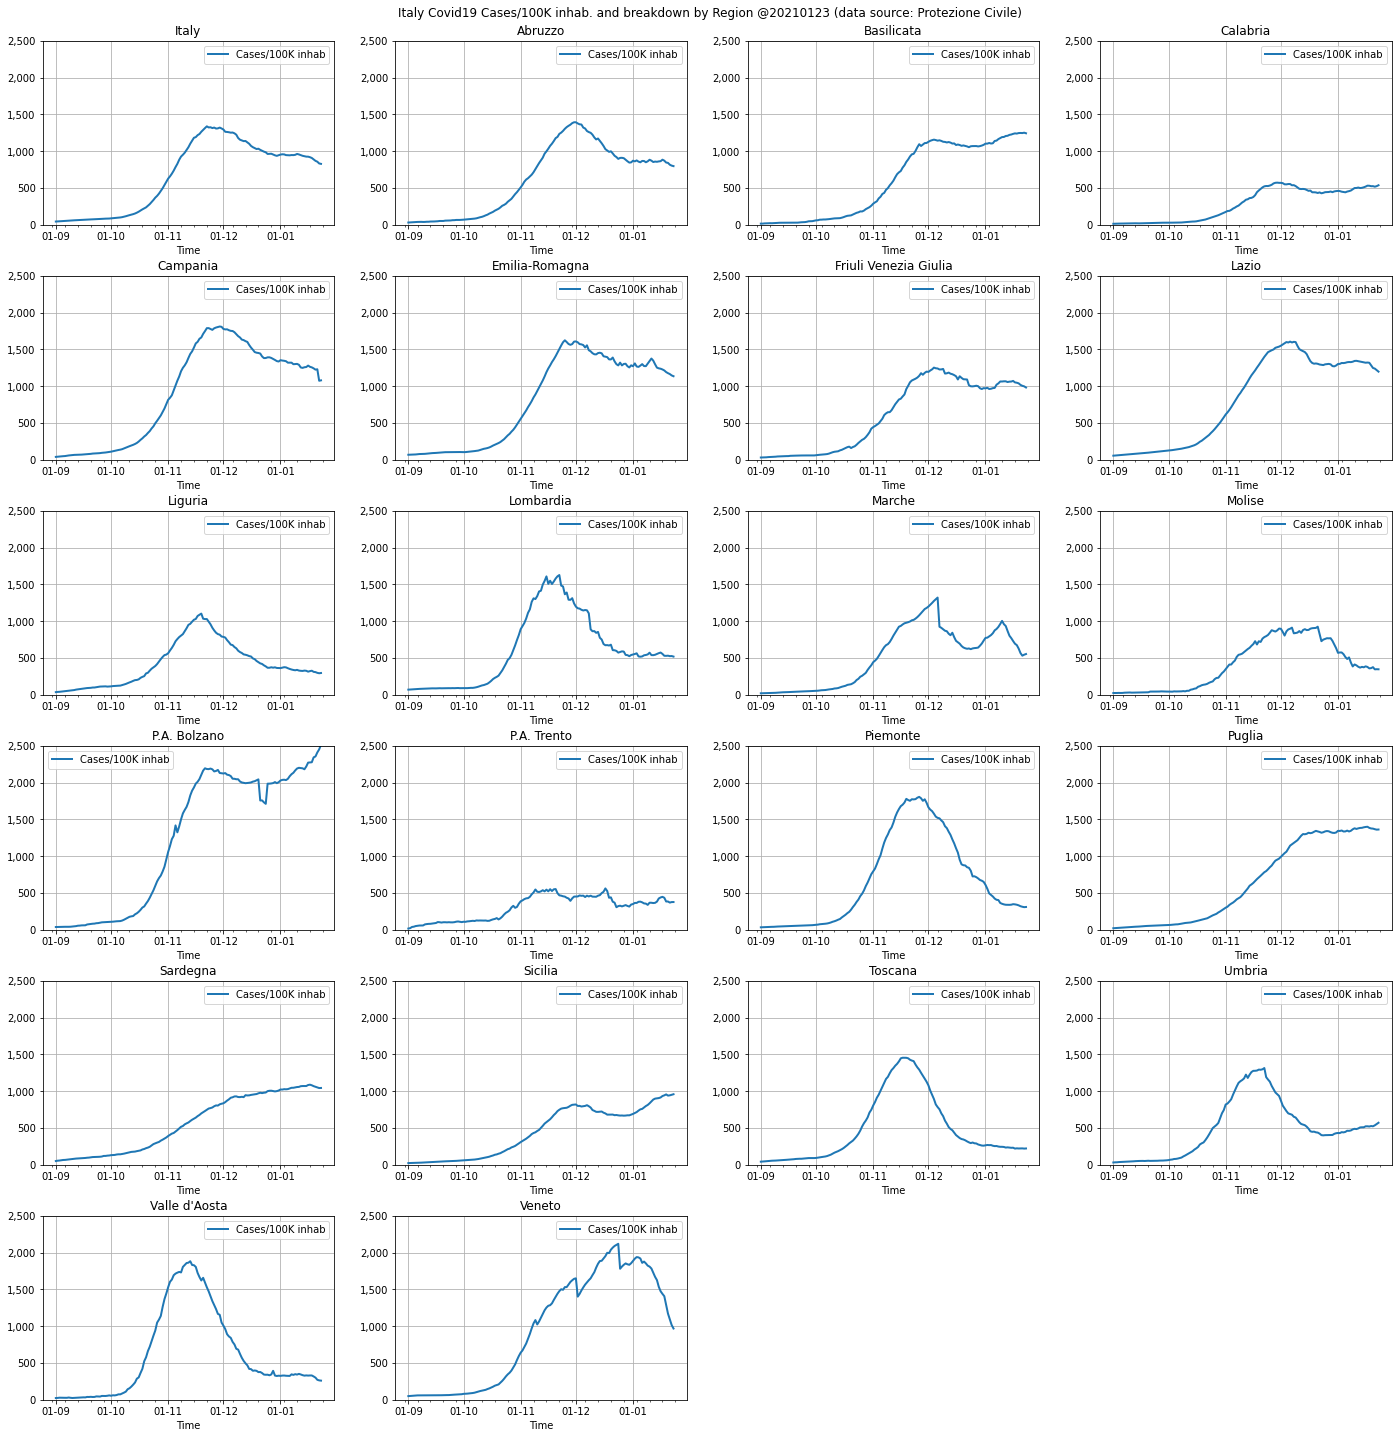

In [ ]:
#%%
#Plot cases/K inhabitants with same y axis scale across differente geographies

nrows=6 
ncols=4
fig, axes = plt.subplots(nrows, ncols,sharex=False,figsize=(20,20)) #
fig.tight_layout(pad=3.0)

population = {'geo': ['Italy','Lombardia', 'Lazio','Campania','Sicilia','Veneto','Emilia-Romagna','Piemonte','Puglia','Toscana','Calabria','Sardegna','Liguria','Marche','Abruzzo','Friuli Venezia Giulia','P.A. Trento','P.A. Bolzano','Trentino-Alto Adige','Umbria','Basilicata','Molise',"Valle d'Aosta"],
        'ab': [60244639,10103969,5865544,5785861,4968410,4907704,4467118,4341375,4008296,3722729,1924701,1630474,1543127,1518400,1305770,1211357,542739,532080,1074819,880285,556934,302265,125501]
        }

dfAb = pd.DataFrame (population, columns = ['geo','ab'])
dfAb.set_index("geo", inplace=True)

date_form = mdates.DateFormatter("%d-%m") #Format date into dd-mm format

regtarget=""
#Main Loop to fill the subplots matrix
idx=0
for r in range(nrows):
  for c in range(ncols):
    if r==0 and c==0: #First select Nationwide data
      df=dfREG.groupby(['data']).sum()
      title='Italy'
      regtarget=title
    elif  idx<=20 : #then select dataframe on a regional basis
      regtarget=regioni[idx]
      df=dfREG.copy()
      df=df[df.denominazione_regione.str.contains(regtarget)==True]
      title=regtarget
      idx=idx+1
    else:
      break


    lastdate=df.index[-1]
    ab=(dfAb.loc[title].ab)
    df['ratiocasi']=df['totale_positivi']/ab*100000
    df['ratiocasi'].plot(kind='line', linestyle="-",lw=2,grid=True,rot=0,legend=False,label='Cases/100K inhab',ax=axes[r,c],sharex=False, sharey=False)
    
    
    axes[r,c].legend()
    axes[r,c].set_xlabel('Time')
    axes[r,c].xaxis.set_major_locator(mdates.MonthLocator())
    axes[r,c].xaxis.set_major_formatter(date_form)
    axes[r,c].xaxis.set_minor_locator(mdates.WeekdayLocator(byweekday=SU))
    axes[r,c].xaxis.set_minor_formatter(ticker.NullFormatter())
    axes[r,c].set_ylim([0,2500])    
    axes[r,c].yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
    axes[r,c].set_title(title)


#Put back bottom labels and clean up unused plots (last two after Italy + 21 regions)
idx=0
for r in range(nrows):
 for c in range(ncols):
     if idx < 22:
         axes[r,c].tick_params(labelbottom=True)
         x_axis=axes[r,c].get_xaxis()
         x_label=x_axis.get_label()
         x_label.set_visible(True)
     else:
         #fig.delaxes(axes[r,c])
         axes[r,c].set_visible(False)
     idx=idx+1
     

today=df.index[-1]
d=today.strftime("%Y%m%d")
fig.suptitle('Italy Covid19 Cases/100K inhab. and breakdown by Region @' + d + ' (data source: Protezione Civile)',y=1.0, x=0.5) 
plt.savefig(d+'ItalyDashboardCases100k_2.png')
plt.show()



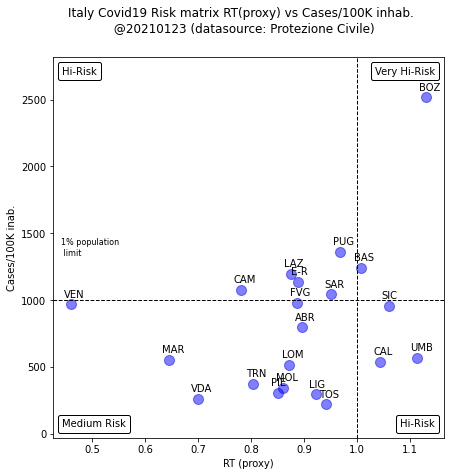

In [ ]:
#%%
#Plot risk matrix combining active case per 100K inhabitants and R(t) a

abbr = {'GEO': ['Italy','Lombardia', 'Lazio','Campania','Sicilia','Veneto','Emilia-Romagna','Piemonte','Puglia','Toscana','Calabria','Sardegna','Liguria','Marche','Abruzzo','Friuli Venezia Giulia','P.A. Trento','P.A. Bolzano','Trentino-Alto Adige','Umbria','Basilicata','Molise',"Valle d'Aosta"],
        'geoid': ['ITA','LOM', 'LAZ','CAM','SIC','VEN','E-R','PIE','PUG','TOS','CAL','SAR','LIG','MAR','ABR','FVG','TRN','BOZ','TAD','UMB','BAS','MOL','VDA']
        }
df_abbr=pd.DataFrame (abbr, columns = ['GEO','geoid'])
pos_matrix=pm.merge(df_abbr,on='GEO')


l=pos_matrix.shape[0]
pos_matrix=pos_matrix[1:l]

fig, ax = plt.subplots(figsize=(7,7))
ax.scatter(pos_matrix['RT'],pos_matrix['RATIO'], color='blue',s=100,lw=1, alpha=0.5)
ax.set_xlabel('RT (proxy)')
ax.set_ylabel('Cases/100K inab.')
leg=""
ax.set_ylim(bottom=pos_matrix['RATIO'].min()-250,top=pos_matrix['RATIO'].max()+ 300)
ax.axhline(y=1000, color='black',lw=1, linestyle='--')
ax.axvline(x=1, color='black',lw=1, linestyle='--')
idx=0

# Add the participant names as text labels for each point
for x_pos, y_pos, label in zip(pos_matrix['RT'], pos_matrix['RATIO'], pos_matrix['geoid']):
    ax.annotate(label,             # The label for this point
                xy=(x_pos, y_pos), # Position of the corresponding point
                xytext=(-7, 10),     # Offset text by 7 points to the right
                textcoords='offset points', # tell it to use offset points
                ha='left',         # Horizontally aligned to the left
                va='center')       # Vertical alignment is centered
    
    leg = leg + pos_matrix['GEO'].iloc[idx] + " (" + pos_matrix['geoid'].iloc[idx]+") \n"
    idx=idx+1

at = AnchoredText("Hi-Risk", prop=dict(size=10), frameon=True,loc='upper left',)
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax.add_artist(at)

at = AnchoredText("Hi-Risk", prop=dict(size=10), frameon=True,loc='lower right',)
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax.add_artist(at)

at = AnchoredText("Very Hi-Risk", prop=dict(size=10), frameon=True,loc='upper right',)
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax.add_artist(at)

at = AnchoredText("Medium Risk", prop=dict(size=10), frameon=True,loc='lower left',)
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax.add_artist(at)
 
at = AnchoredText("1% population \n limit", prop=dict(size=8), frameon=False,loc='center left',)
#at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax.add_artist(at)

today=df.index[-1]
d=today.strftime("%Y%m%d")
fig.suptitle('Italy Covid19 Risk matrix RT(proxy) vs Cases/100K inhab. \n @' + d + ' (datasource: Protezione Civile)')
plt.savefig(d+'ItalyDashboardRiskMatrix.png')
plt.show()


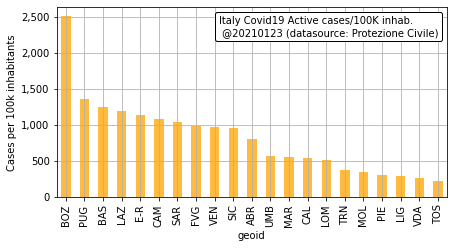

In [ ]:
#%%
#Plot Bar chart of active cases per 100k inhbinats per geography in descending order

fig, ax = plt.subplots(figsize=(7,3.5))
PM=pos_matrix.copy()
#PM.reset_index(drop=True)
PM.set_index('geoid',inplace=True)
PM=PM.sort_values(by=['RATIO'], ascending=False)
ax = PM['RATIO'].plot(kind='bar',alpha=0.75,grid=True, color='orange')
#ax.set_xlabel("Hour",fontsize=12)
ax.set_ylabel("Cases per 100k inhabitants",fontsize=10)
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
at = AnchoredText('Italy Covid19 Active cases/100K inhab. \n @' + d + ' (datasource: Protezione Civile)', prop=dict(size=10), frameon=True,loc='upper right',)
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax.add_artist(at)
d=today.strftime("%Y%m%d")
#fig.suptitle('Italy Covid19 Active cases/100K inhab. \n @' + d + ' (datasource: Protezione Civile)')
plt.savefig(d+'ItalyDashboardCase100KGeo_Bar.png')
plt.show()
PM.reset_index(inplace=True)
#PM

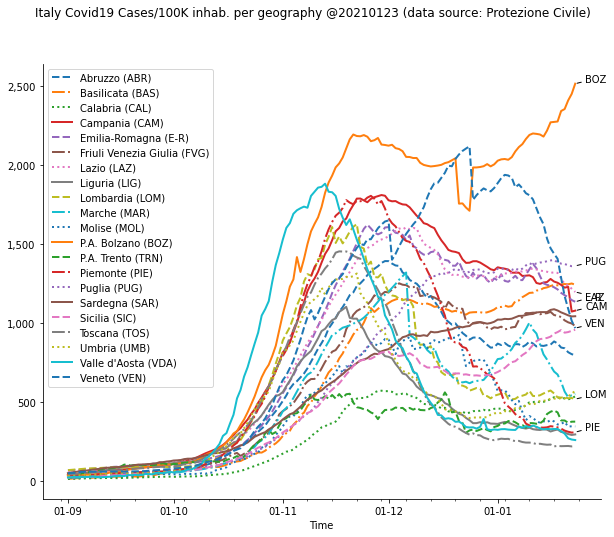

In [ ]:
#%%
#Plot line chart of cases/100.000 inhabitants per geography

NUM_COLORS = 20
LINE_STYLES = ['solid', 'dashed', 'dashdot', 'dotted']
NUM_STYLES = len(LINE_STYLES)

population = {'geo': ['Italy','Lombardia', 'Lazio','Campania','Sicilia','Veneto','Emilia-Romagna','Piemonte','Puglia','Toscana','Calabria','Sardegna','Liguria','Marche','Abruzzo','Friuli Venezia Giulia','P.A. Trento','P.A. Bolzano','Trentino-Alto Adige','Umbria','Basilicata','Molise',"Valle d'Aosta"],
        'ab': [60244639,10103969,5865544,5785861,4968410,4907704,4467118,4341375,4008296,3722729,1924701,1630474,1543127,1518400,1305770,1211357,542739,532080,1074819,880285,556934,302265,125501],
        'geoid': ['ITA','LOM', 'LAZ','CAM','SIC','VEN','E-R','PIE','PUG','TOS','CAL','SAR','LIG','MAR','ABR','FVG','TRN','BOZ','TAD','UMB','BAS','MOL','VDA']
        }

dfAb = pd.DataFrame (population, columns = ['geo','ab','geoid'])
dfAb.set_index("geo", inplace=True)

fig, ax = plt.subplots(figsize=(10,8)) #

date_form = mdates.DateFormatter("%d-%m") #Format date into dd-mm format
MA=7 #moving average window


msk='LOMBOZCAMVENE-RLAZPUGPIE'#Show only labels included in this mask 
idx=0
for regtarget in regioni:
    
    df=dfREG.copy()
    df=df[df.denominazione_regione.str.contains(regtarget)==True]
    idx=idx+1
    ab=(dfAb.loc[regtarget].ab)
    geoid=(dfAb.loc[regtarget].geoid)
    df['ratiocasi']=df['totale_positivi']/ab*100000
    df['ratiocasi'].plot(kind='line', linestyle=LINE_STYLES[idx%4],lw=2,rot=0,legend=False,label=regtarget+" ("+geoid+")")
    
    lastdate=df.index[-1]
    ex=df.iloc[-1].ratiocasi
    if geoid=='LAZ': 
        dy=-10
    else:
        dy=0
    
    if geoid in msk: 
        ax.annotate(geoid,xy=(lastdate,ex) , xytext=(10,5+dy),fontsize=10,textcoords='offset points', va='center',arrowprops=dict(facecolor='black', arrowstyle="-"))     #textcoords='offset points' arrowprops=dict(facecolor='black', arrowstyle="-") xytext=(10+dx,0)

ax.set_xlabel('Time')
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_minor_locator(mdates.WeekdayLocator(byweekday=SU))
ax.xaxis.set_minor_formatter(ticker.NullFormatter())
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ','))) 
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
    
ax.legend()
today=df.index[-1]
d=today.strftime("%Y%m%d")
fig.suptitle('Italy Covid19 Cases/100K inhab. per geography @'+d+' (data source: Protezione Civile)') 
plt.savefig(d+'ItalyDashboardCase100KGeo.png')
plt.show()


In [ ]:
#%%
#Prepare datasets for heatmap for active cases per 100k inhabitants, sum of last 7 days new cases and R(t)
k=7
gamma=1/9
population = {'geo': ['Italy','Lombardia', 'Lazio','Campania','Sicilia','Veneto','Emilia-Romagna','Piemonte','Puglia','Toscana','Calabria','Sardegna','Liguria','Marche','Abruzzo','Friuli Venezia Giulia','P.A. Trento','P.A. Bolzano','Trentino-Alto Adige','Umbria','Basilicata','Molise',"Valle d'Aosta"],
        'ab': [60244639,10103969,5865544,5785861,4968410,4907704,4467118,4341375,4008296,3722729,1924701,1630474,1543127,1518400,1305770,1211357,542739,532080,1074819,880285,556934,302265,125501]
        }

dfAb = pd.DataFrame (population, columns = ['geo','ab'])
dfAb.set_index("geo", inplace=True)
dfRatio= pd.DataFrame()
dfNewcaseRatio=pd.DataFrame()
dfRt=pd.DataFrame()
date_form = mdates.DateFormatter("%d-%m") #Format date into dd-mm format
len(regioni)
regtarget=""
#Main Loop to fill the subplots matrix
idx=0
while idx < len(regioni):

    regtarget=regioni[idx]
    df=dfREG.copy()
    df=df[df.denominazione_regione.str.contains(regtarget)==True]
    idx=idx+1
    today=df.index[-1]
    lastdate=df.index[-1]
    ab=(dfAb.loc[regtarget].ab)
    df[regtarget]=df['totale_positivi']/ab*100000
    df[regtarget+"_Nc"]=df['nuovi_positivi'].rolling(7).sum()/ab*100000
    df['LNCasi']=np.log(df['totale_positivi'])
    df['dLNCasi']=df['LNCasi'].diff(periods=k)/k
    df[regtarget+"_Rt"]=(df['dLNCasi']+gamma)/gamma
    dfRatio=dfRatio.append(df[regtarget])
    dfNewcaseRatio=dfNewcaseRatio.append(df[regtarget+"_Nc"])
    dfRt=dfRt.append(df[regtarget+"_Rt"])

#dfRt.head(25)   

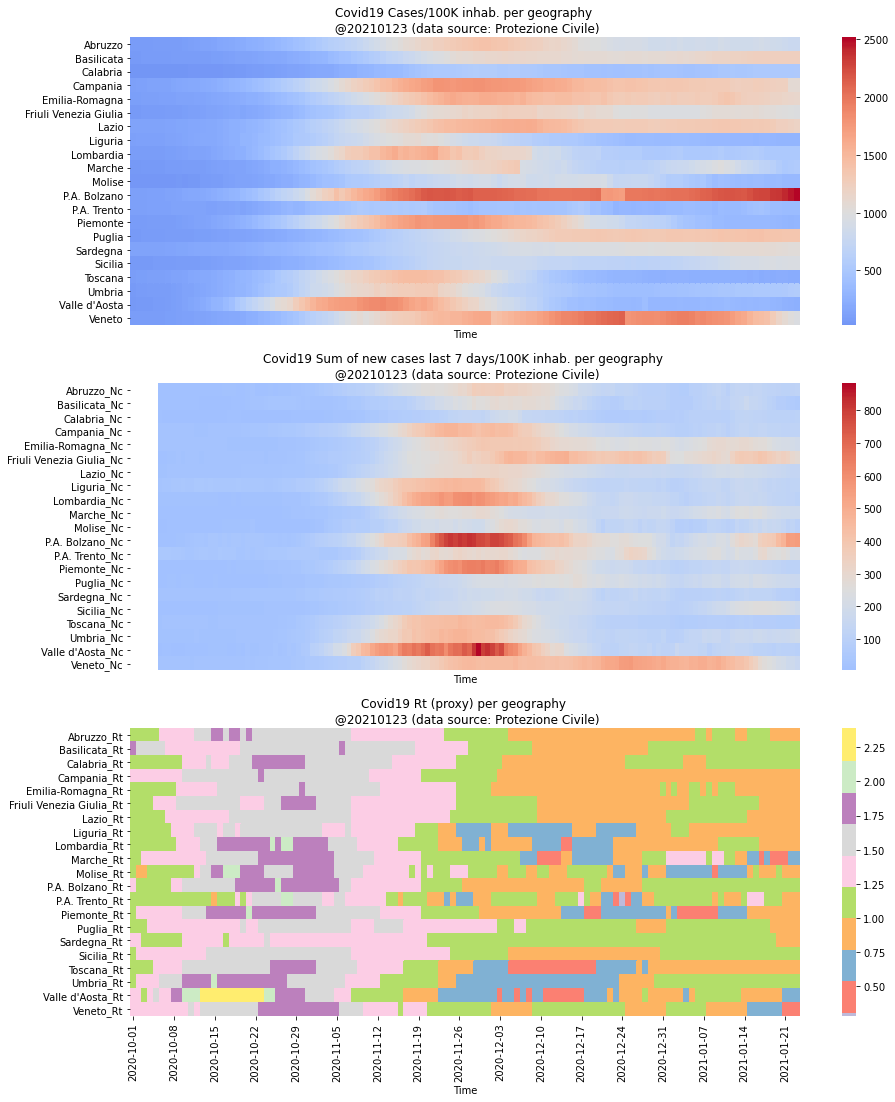

In [ ]:
#Plot HEATMAP of cases per 100k inhabitants, sum of last 7 days new cases and R(t)
d=today.strftime("%Y%m%d")

title_txt1=('Covid19 Cases/100K inhab. per geography \n @'+d+' (data source: Protezione Civile)')
title_txt2=('Covid19 Sum of new cases last 7 days/100K inhab. per geography \n @'+d+' (data source: Protezione Civile)')
title_txt3=('Covid19 Rt (proxy) per geography \n @'+d+' (data source: Protezione Civile)')

fig, axes = plt.subplots(nrows=3,ncols=1,figsize=(15,18))
#fig.tight_layout(pad=5.5)
sns.heatmap(dfRatio.iloc[:,30:],xticklabels=False,cmap="coolwarm",center = 1000.0,ax=axes[0])
axes[0].set(title=title_txt1,xlabel="Time")

sns.heatmap(dfNewcaseRatio.iloc[:30:],xticklabels=False,cmap='coolwarm',center = 250.0,ax=axes[1]) #Oranges cividis
axes[1].set(title=title_txt2,xlabel="Time")

sns.heatmap(dfRt.iloc[:,30:],xticklabels=7,cmap='Set3',center = 1,ax=axes[2]) #Oranges cividis
axes[2].set(title=title_txt3,xlabel="Time")
plt.savefig(d+'ItalyDashboardHeatmap.png')
plt.show()


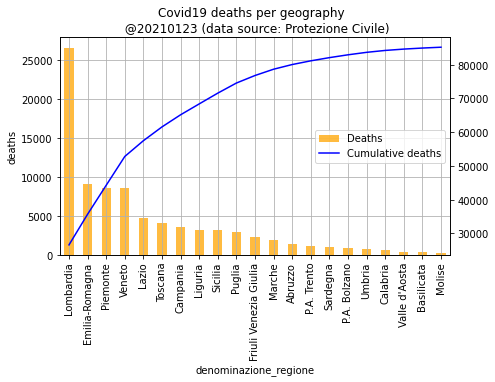

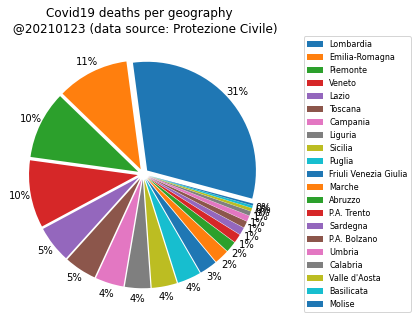

<Figure size 432x288 with 0 Axes>

In [ ]:
#%%
#Plot total deaths per geography
dfREG.head()
df=dfREG.copy()
today=df.index[-1]

df=df.loc[today]
df.set_index('denominazione_regione',inplace=True)
df=df.sort_values(by=['deceduti'], ascending=False)
df['run_dec'] = df['deceduti'].cumsum()

fig, ax = plt.subplots(figsize=(7,4))
df['deceduti'].plot(kind='bar',alpha=0.75,grid=True, color='orange',label="Deaths",ax=ax)
ax.set_ylabel("deaths")
ax2=ax.twinx()
df['run_dec'].plot(kind='line',grid=False, color='blue', label="Cumulative deaths",ax=ax2)

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='center right')


title=('Covid19 deaths per geography  \n @'+d+' (data source: Protezione Civile)')
plt.title(title)
plt.savefig(d+'ItalyDashboardDeaths_bar.png')
plt.show()


fig, ax = plt.subplots(figsize=(5,5))
df.plot.pie(y='deceduti',ylabel="",ax=ax,explode=[0.05]*21,autopct='%1.0f%%',labeldistance=None,pctdistance=1.1,startangle=-15)
title=('Covid19 deaths per geography  \n @'+d+' (data source: Protezione Civile)')
plt.title(title)
plt.legend(bbox_to_anchor=(1.5, 0.5),fontsize="8",loc="right")
plt.show()
plt.savefig(d+'ItalyDashboardDeaths_pie.png')

df.reset_index(inplace=True)
